We have learned how to implement a model and train it from stratch. However, for pratical machine learning tasks, we often reuse popular model architectures and load pre-trained weights on famous large datasets and fine-tune with our own small, specific dataset, which is called transfer learning. In this notebook we will load a pre-trained ConvNet and use it for our own goal.

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

In [2]:
def show_images(dataset, class_names, predicts=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.8, wspace=0.4)
    for i, (image, label) in enumerate(dataset):
        if i>= 9: 
            break
        if image.shape[-1] == 1:
            revised_image = np.squeeze(image)
        else:
            revised_image = image
        axes.flat[i].imshow(revised_image)
        # Name of the true class.
        label_name = class_names[label]
        
        # Show true and predicted classes.
        if predicts is None:
            axes.flat[i].set_xlabel("True : {0}".format(label_name))
        else:
            predict_name = class_names[predicts[i]]
            axes.flat[i].set_xlabel("True: {0}\nPred: {1}".format(label_name, predict_name))
        # Remove ticks from the plot.
        axes.flat[i].set_xticks([])
        axes.flat[i].set_yticks([])
    while(i < 8):
        i += 1
        axes.flat[i].axis('off')
    plt.show()

You can find famous ConvNets in keras.applications.

In [3]:
baseModel = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet',include_top=False)

In [4]:
baseModel.trainable = False
cnnModel = keras.Sequential([baseModel,
                      layers.Flatten(),
                  layers.Dense(units = 512, activation = 'relu'), 
                  layers.Dense(units = 3, activation = 'softmax')])
cnnModel.summary()
print("Number of layers in VGG16: ", len(baseModel.layers))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 12,847,107
Non-trainable params: 14,714,688
_________________________________________________________________
Number of layers in VGG16:  19


In [5]:
filenames = []
labels = []
class_names = ['bird','cat','dog']
for filename in os.listdir("./data"):
    if filename.startswith("bird"):
        labels.append(0)
        filenames.append(os.path.join("./data",filename))
    elif filename.startswith("cat"):
        labels.append(1)
        filenames.append(os.path.join("./data",filename))
    elif filename.startswith("dog"):
        labels.append(2)
        filenames.append(os.path.join("./data",filename))
print(filenames)
print(labels)
path_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

['./data\\bird (10).jpg', './data\\bird (11).jpg', './data\\bird (12).jpg', './data\\bird (13).jpg', './data\\bird (14).jpg', './data\\bird (15).jpg', './data\\bird (16).jpg', './data\\bird (17).jpg', './data\\bird (18).jpg', './data\\bird (19).jpg', './data\\bird (2).jpg', './data\\bird (20).jpg', './data\\bird (21).jpg', './data\\bird (22).jpg', './data\\bird (23).jpg', './data\\bird (24).jpg', './data\\bird (25).jpg', './data\\bird (26).jpg', './data\\bird (27).jpg', './data\\bird (28).jpg', './data\\bird (29).jpg', './data\\bird (3).jpg', './data\\bird (30).jpg', './data\\bird (31).jpg', './data\\bird (32).jpg', './data\\bird (33).jpg', './data\\bird (34).jpg', './data\\bird (35).jpg', './data\\bird (36).jpg', './data\\bird (37).jpg', './data\\bird (38).jpg', './data\\bird (39).jpg', './data\\bird (4).jpg', './data\\bird (40).jpg', './data\\bird (5).jpg', './data\\bird (6).jpg', './data\\bird (7).jpg', './data\\bird (8).jpg', './data\\bird (9).jpg', './data\\bird.jpg', './data\\cat

In [6]:
def load_and_preprocess_image(filename, label):
    raw_image = tf.io.read_file(filename)
    image_tensor = tf.image.decode_jpeg(raw_image)
    image_tensor = tf.image.resize(image_tensor, [224, 224])
    image_tensor /= 255.0
    return image_tensor,label

In [7]:
imageDataset = path_dataset.shuffle(buffer_size=100,reshuffle_each_iteration=False).map(load_and_preprocess_image)
trainDataset = imageDataset.take(int(len(filenames)* 0.7))
valDataset = imageDataset.skip(int(len(filenames)* 0.7))

In [8]:
cnnModel.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
             loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('checkpoint/transfer_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
]
history = cnnModel.fit(trainDataset.batch(5).prefetch(buffer_size=10),  epochs=20, validation_data=valDataset.batch(5), callbacks = callbacks)

Epoch 1/20
17/17 [==============================] - 25s 1s/step - loss: 2.4072 - sparse_categorical_accuracy: 0.3810 - val_loss: 0.5037 - val_sparse_categorical_accuracy: 0.7778
Epoch 2/20
17/17 [==============================] - 26s 2s/step - loss: 0.3620 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.4802 - val_sparse_categorical_accuracy: 0.8056
Epoch 3/20
17/17 [==============================] - 25s 1s/step - loss: 0.0719 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4340 - val_sparse_categorical_accuracy: 0.8611
Epoch 4/20
17/17 [==============================] - 26s 2s/step - loss: 0.0271 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4053 - val_sparse_categorical_accuracy: 0.8611
Epoch 5/20
17/17 [==============================] - 25s 1s/step - loss: 0.0141 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4403 - val_sparse_categorical_accuracy: 0.8333
Epoch 6/20
17/17 [==============================] - 26s 2s/step - loss: 0.0549 - sparse_categorical_accuracy: 

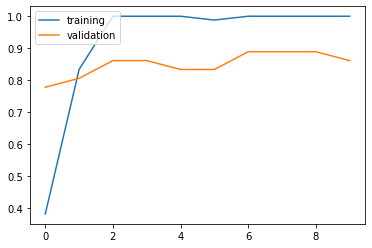

In [10]:
# history record the accuracy/loss on training set/validation set after every epoch 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [11]:
result = cnnModel.evaluate(valDataset.batch(10))

4/4 [==============================] - 5s 1s/step - loss: 0.4063 - sparse_categorical_accuracy: 0.8611


In [12]:
some_samples = valDataset.take(9)

In [13]:
predict_result = tf.argmax(cnnModel.predict(some_samples.batch(9)),axis=1)

In [14]:
predict_result.numpy()

array([2, 2, 1, 2, 2, 0, 2, 2, 1], dtype=int64)

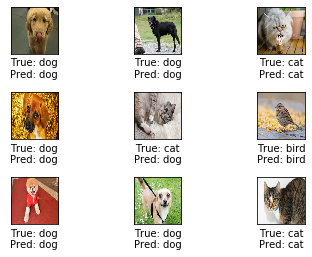

In [15]:
show_images(some_samples, class_names, predict_result)